In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import binary_erosion, binary_dilation, disk, square
from sklearn.decomposition import PCA
import pandas as pd
import sklearn
# from sklearn_xarray import wrap

In [3]:
# Open dataset
# tripmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/run_3/mad-20150101-20161231_15_-22.nc')
tripmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/mad-20150101-20161231_11_-40.nc')
# tripmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/mad-20150101-20161231_14_-41.nc')

In [4]:
# x, y = 1577885, -2179369
# size = 100000
# minx, maxx = x-size, x+size
# miny, maxy = y-size, y+size
# tripmad_sample = tripmad.sel(x = slice(minx, maxx), y = slice(maxy, miny))
# tripmad_sample = tripmad.isel(x=slice(2500, 4000), y=slice(2500, 4000))
tripmad_sample = tripmad.isel(x=slice(500,2000), y=slice(500, 2000))

In [5]:
# Drop unecessary variables
a = tripmad.drop(['dataset', 'crs', 'time'])

a = a.squeeze()

# Convert dataset to dataarray with each variable broadcast against each other
a = a.to_array()

# # Stack the dimensions
a = a.stack(features=['x', 'y'])#.values

In [6]:
# Extract the underlying numpy array
b = a.data

# Number of samples
n_samples = b.shape[0]

# Number of features / attributes
grid_shape = b.shape[1:]
n_grids = np.prod(grid_shape)

# Reshape array to samples, features
b = b.reshape((n_samples, n_grids))

# Boolean mask to remove Nans
valid_grids = ~np.isnan(b[0,:])
b = b[:,valid_grids]

In [7]:
# Set PCA variables
pca = PCA(n_components=1)

# Fit PCA
c = pca.fit(b)

In [8]:
### reshape the coefficient array back ###

# Create empty array with the dimensions of the PCA output
eofs = np.empty((c.n_components_, n_grids)) * np.nan
# Assign components from PCA to each grid location in empty array
eofs[:, valid_grids] = c.components_
# Reshape array 
eofs = eofs.reshape((c.n_components_,) + grid_shape)

### Reshape the mean_ ###

# Create an empty array the size of the number of grids
mean_ = np.empty(n_grids) * np.nan
# Populate empty array with values
mean_[valid_grids] = c.mean_
# Resahpe to match grid size
mean_ = mean_.reshape(grid_shape)

### wrap regression coefficient into DataArray ###

# extract dimension names from input DataArray
grid_dims = a.dims[1:]
eofs_dims = a.dims
# Extract the coords for the features dimension
grid_coords = {dim: a[dim] for dim in grid_dims}
# Assign these to the output coords variable 
eofs_coords = grid_coords.copy()
# Add an array to the output coords with the size of the out PCA dimensions and the key of the dimensions
eofs_coords[eofs_dims[0]] = np.arange(c.n_components_)
# Add new DataArray of components (directions of maximum variance int he data) to the PCA output
c.components_da = xr.DataArray(eofs,
    dims=eofs_dims, coords=eofs_coords)
#A Add new Dataarray of per feature empirical mean_ to the PCA output
c.mean_da = xr.DataArray(mean_,
    dims=grid_dims, coords=grid_coords)
# Extract DataArray output
d = c.mean_da.unstack()

In [9]:
d = d.to_dataset(name='temp').transpose()
d = d.to_array().squeeze()
e = c.components_da.unstack().isel(variable=0)
e = e.to_dataset(name='temp').transpose()
e = e.to_array().squeeze()

In [10]:
# # Drop unecessary variables
# f = tripmad.drop(['dataset', 'crs', 'time'])

# f = f.squeeze()

# # Convert dataset to dataarray with each variable broadcast against each other
# f = f.to_array()

# l = f.stack(features=['x', 'y'])

# g = l.unstack()

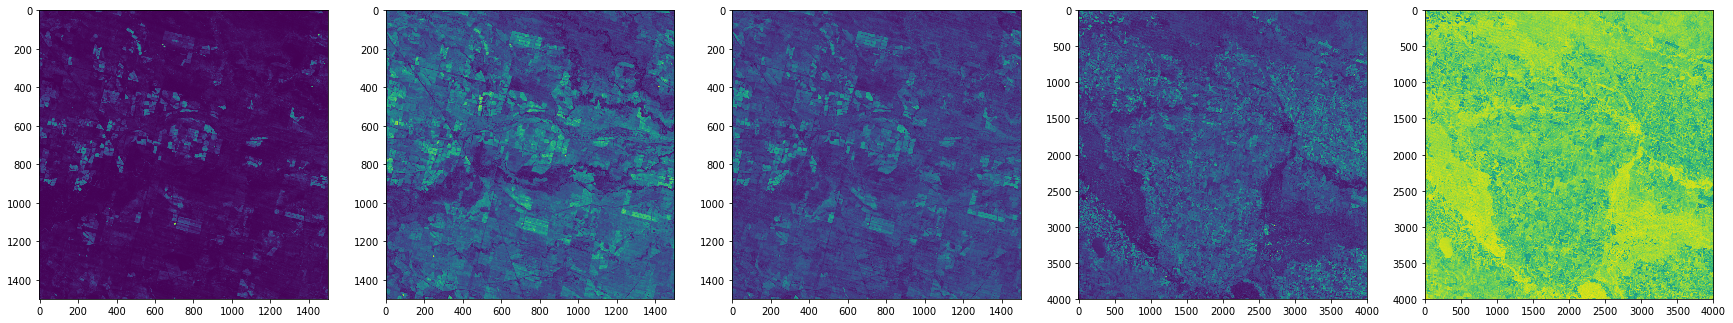

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(30,20))
axes[0].imshow(tripmad_sample.sdev.isel(time=0))
axes[1].imshow(tripmad_sample.edev.isel(time=0))
axes[2].imshow(tripmad_sample.bcdev.isel(time=0))
axes[3].imshow(d)
axes[4].imshow(e)

# Image segmentation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.segmentation import quickshift
import sklearn.feature_extraction.image
import sklearn.cluster
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy import stats
import scipy
from skimage.filters import threshold_otsu, rank

In [13]:
# read in max ndvi data and convert to Numpy array

# img_path = '/g/data/u46/users/sc0554/cult_area/run_3/woody_ndvi.tif'
img_path = '/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/woody_11_-40.nc'
# img_path = '/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/woody_14_-41.nc'
# img = io.imread(image)
# img = xr.open_rasterio(img_path)
img = xr.open_dataset(img_path)
img_v = np.squeeze(img['veg'].values).astype(float)
img_s = img['veg'].isel(x=slice(2500, 4000), y=slice(2500, 4000))
img_sv = np.squeeze(img_s.values).astype(float)

In [14]:
# Segment the  max ndvi numpy array

%%time
# Note: convert2lab=False allows the use of multiband images
segments_quickshift = quickshift(img_v, kernel_size=5, convert2lab=False, max_dist=500, ratio=0.5)
print("Quickshift number of segments: %d" % len(np.unique(segments_quickshift)))
# %%time
# # SLIC can handle multiband images
# segments_slic = slic(img_sv, n_segments=800, compactness=.2, sigma=2, max_size_factor=1, max_iter=10, multichannel=True)
# print("SLIC number of segments: %d" % len(np.unique(segments_slic)))
# # print(segments_slic)

Quickshift number of segments: 7808
CPU times: user 10min 26s, sys: 679 ms, total: 10min 27s
Wall time: 10min 27s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


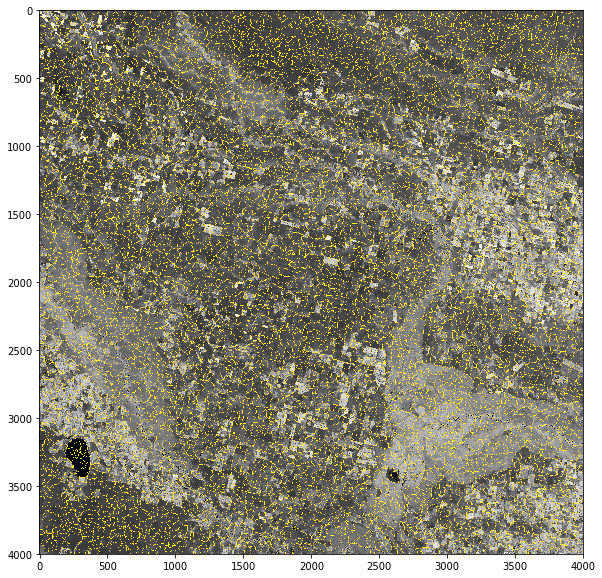

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mark_boundaries(img_v, segments_quickshift))

In [48]:
# Calculate the median max ndvi value for each segment

seg_median = scipy.ndimage.median(input=img_v, labels=segments_quickshift, index=segments_quickshift)

In [84]:
# Calculate the optimum threshold for max NDVI
thresh = threshold_otsu(seg_median)
# Filter by the threshold
thresh_seg_median = seg_median > thresh

# seg_median_filt = np.where(seg_median_filt > 0.4, 1, 0)
# seg_median_filt = np.where(seg_median_filt > 0.55, 1, 0) # tville

0.4679837175644934


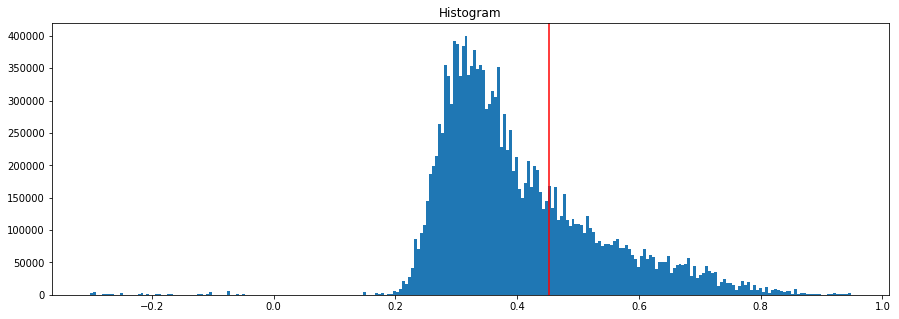

In [85]:
print(thresh_seg)
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(seg_median.ravel(), bins=256)
ax.set_title('Histogram')
ax.axvline(thresh, color='r')

In [86]:
# Create an empty numpy array with the same shapre as the input
img_fill = np.ones((img_v.shape))
# Assign the segment size values to each value belonging to that 
seg_size = scipy.ndimage.sum(input=img_fill, labels=segments_quickshift, index=segments_quickshift)
print(np.unique(seg_size))

[  188.   240.   261. ... 10409. 10542. 11356.]


In [87]:
# Filter by segment size
thresh_seg_median_filt = np.where((seg_size > 500) & (seg_size < 5000), thresh_seg_median, 0) # previously 2000 for small size
# seg_median_filt = np.where((seg_size > 2000) & (seg_size < 19000), seg_median, 0) # Tville

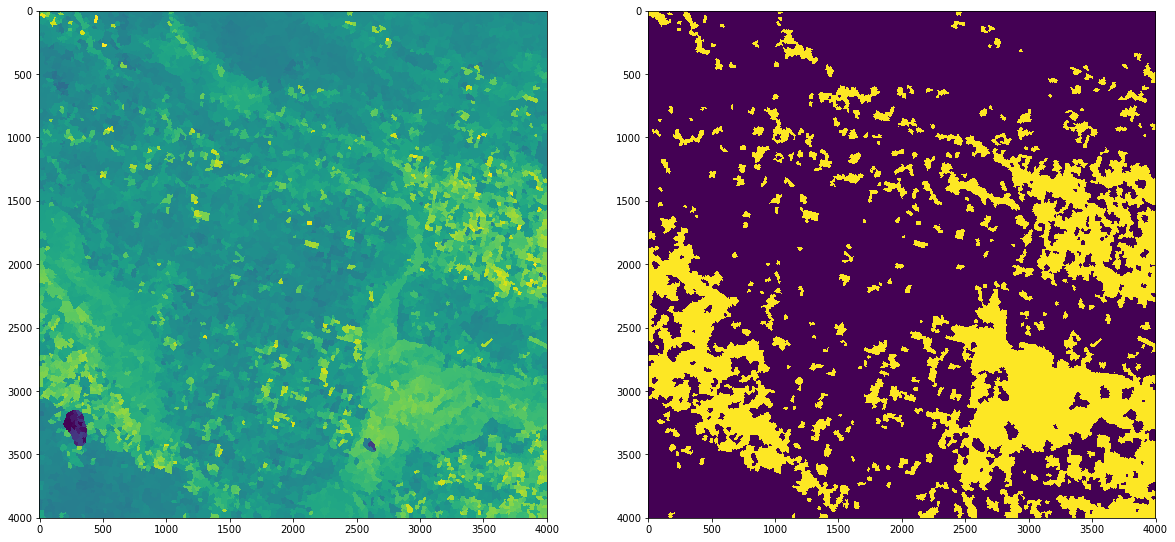

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(seg_median)
ax[1].imshow(thresh_seg_median_filt)

### MAD filtering

In [89]:
from scipy import ndimage

In [90]:
tripmad_np = d.data

In [91]:
print(np.min(tripmad_np), np.max(tripmad_np))

0.01322022546082735 0.24284164607524872


In [92]:
tripmad_filt = np.where(tripmad_np > 0.07, True, False)

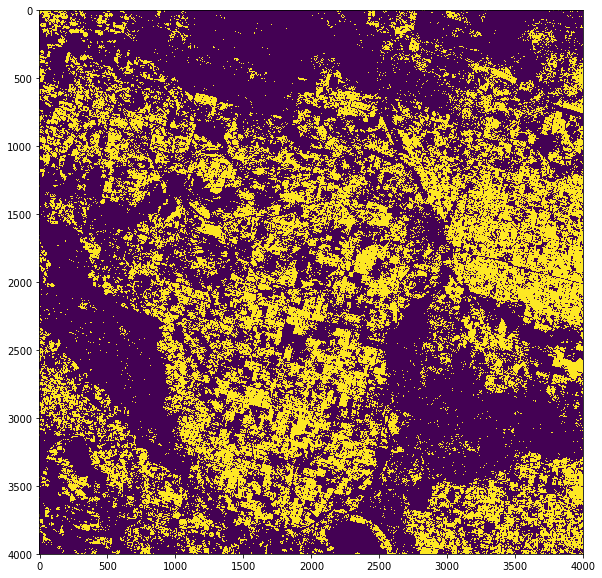

In [93]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(tripmad_filt)

## Segmentation and MAD combination

In [94]:
cult_area = np.logical_and(tripmad_filt, thresh_seg_median_filt)
# cult_area = np.where(cult_area == True, 1, 0)

In [95]:
cult_area_filt = ndimage.median_filter(cult_area, 4)
cult_area_filt = np.where(cult_area_filt == True, 1, 0).astype(float)

In [96]:
erosion_cult = binary_erosion(cult_area, square(2))

In [97]:
dilation_cult = binary_dilation(erosion_cult, square(2))

# Plot processing stages

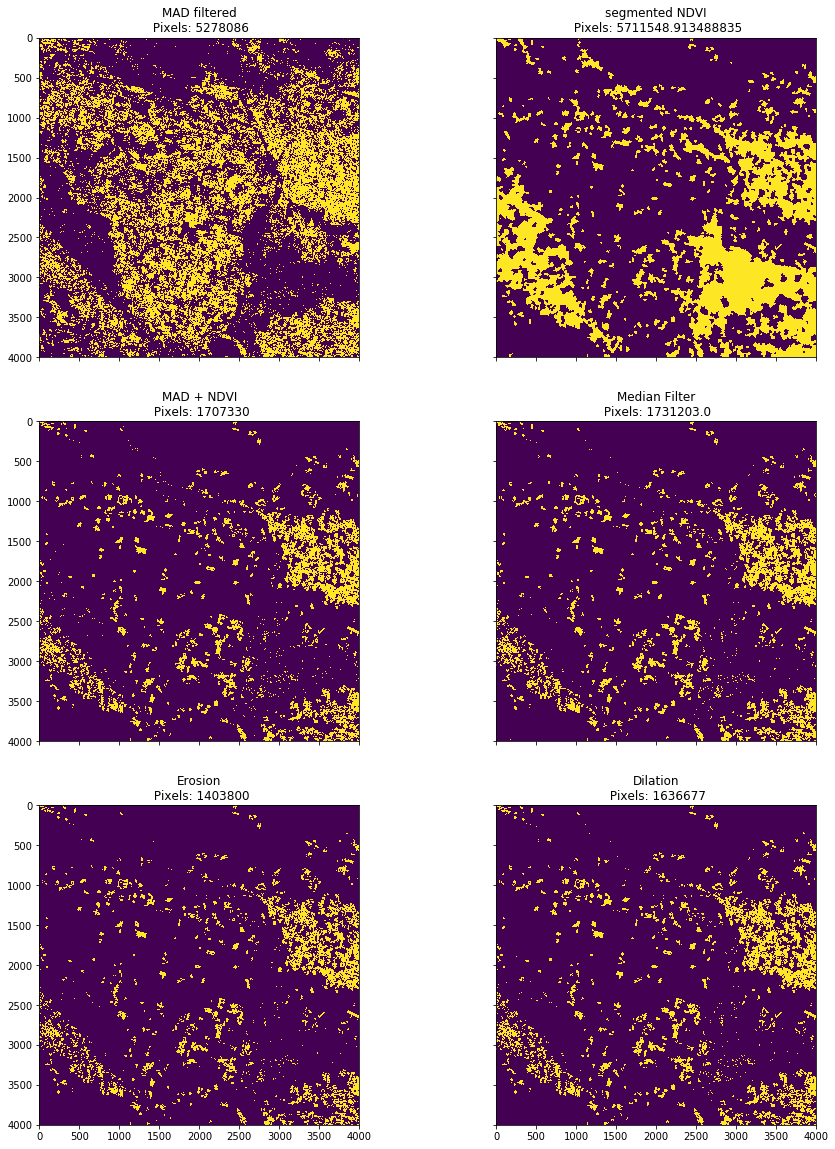

In [98]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,20), sharex=True, sharey=True)
ax[0][0].imshow(tripmad_filt)
ax[0][0].set_title('MAD filtered' + '\n Pixels: ' + str(np.sum(tripmad_filt)))
ax[0][1].imshow(thresh_seg_median_filt)
ax[0][1].set_title('segmented NDVI' + '\n Pixels: ' + str(np.sum(seg_median_filt)))
ax[1][0].imshow(cult_area)
ax[1][0].set_title('MAD + NDVI' + '\n Pixels: ' + str(np.sum(cult_area)))
ax[1][1].imshow(cult_area_filt)
ax[1][1].set_title('Median Filter' + '\n Pixels: ' + str(np.sum(cult_area_filt)))
ax[2][0].imshow(erosion_cult)
ax[2][0].set_title('Erosion' + '\n Pixels: ' + str(np.sum(erosion_cult)))
ax[2][1].imshow(dilation_cult)
ax[2][1].set_title('Dilation' + '\n Pixels: ' + str(np.sum(dilation_cult)))
fig.savefig('cultareaprocess')

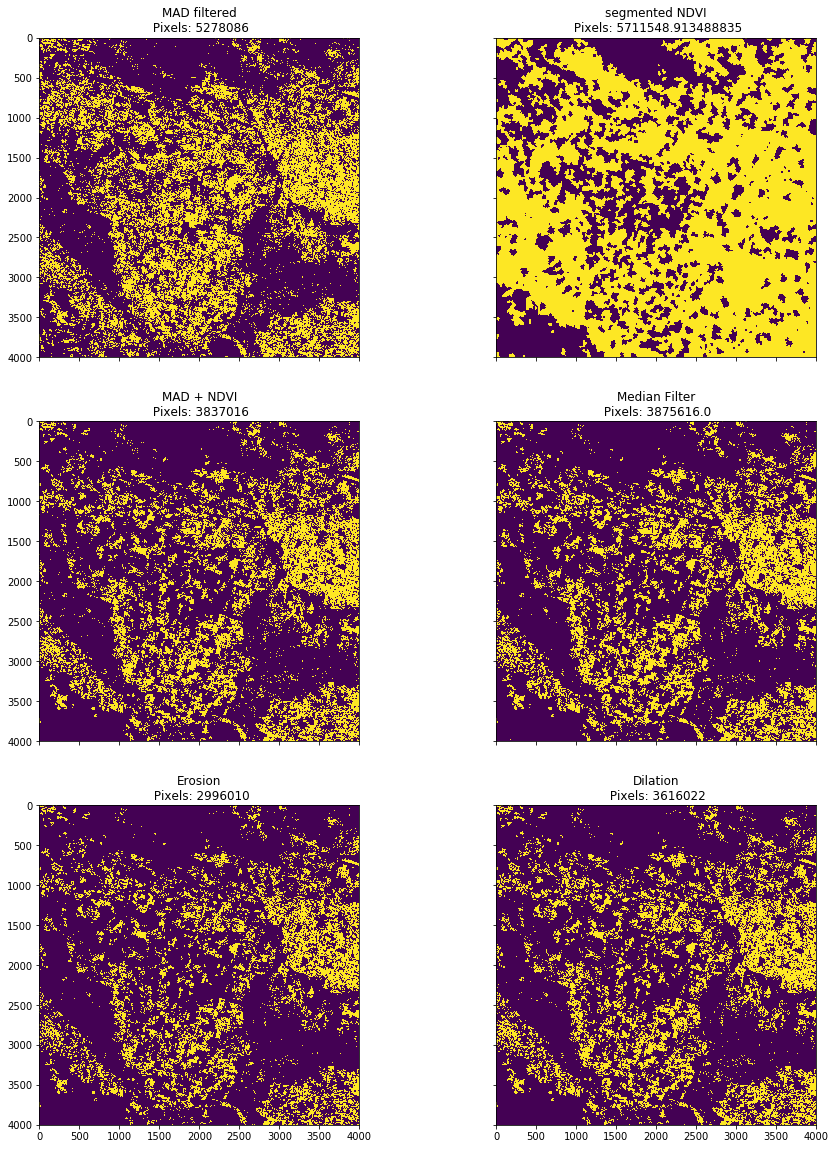

In [83]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,20), sharex=True, sharey=True)
ax[0][0].imshow(tripmad_filt)
ax[0][0].set_title('MAD filtered' + '\n Pixels: ' + str(np.sum(tripmad_filt)))
ax[0][1].imshow(thresh_seg_median_filt)
ax[0][1].set_title('segmented NDVI' + '\n Pixels: ' + str(np.sum(seg_median_filt)))
ax[1][0].imshow(cult_area)
ax[1][0].set_title('MAD + NDVI' + '\n Pixels: ' + str(np.sum(cult_area)))
ax[1][1].imshow(cult_area_filt)
ax[1][1].set_title('Median Filter' + '\n Pixels: ' + str(np.sum(cult_area_filt)))
ax[2][0].imshow(erosion_cult)
ax[2][0].set_title('Erosion' + '\n Pixels: ' + str(np.sum(erosion_cult)))
ax[2][1].imshow(dilation_cult)
ax[2][1].set_title('Dilation' + '\n Pixels: ' + str(np.sum(dilation_cult)))
fig.savefig('cultareaprocess')

# Convert back to xarray

In [514]:
from datacube import helpers
from datacube.utils import geometry

In [515]:
# meta_d = img_s.squeeze().drop('band') tville
meta_d = img.squeeze().drop('time')
# meta_d = img_s.squeeze().drop('time')

In [516]:
# out = xr.DataArray(cult_area_filt, coords=meta_d.coords, dims=meta_d.dims)
out = xr.Dataset({'cult_area':(meta_d.dims,cult_area_filt)}, coords=meta_d.coords, attrs=meta_d.attrs)
# out.attrs = meta_d.attrs
out.attrs['crs']=geometry.CRS(meta_d_a.crs.attrs['crs_wkt'])

In [517]:
helpers.write_geotiff('caf_barmah.tif', out)

In [374]:
out.to_netcdf('caf_pca_snowy2.nc')

In [378]:
x = xr.open_dataset('Output/caf_pca_snowy.nc')

In [392]:
img.coords

Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -4e+06 -4e+06 -4e+06 ... -4.1e+06 -4.1e+06 -4.1e+06
  * x        (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.5e+06 1.5e+06 1.5e+06